In [ ]:
pip install textblob


In [ ]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
import regex as re
from textstat.textstat import textstat
from textblob import TextBlob


In [ ]:
sns.set_theme(style="whitegrid")

# Main Dataset

# Sentiment score data
# This is the same as the conversation data set with added sentiment columns for prompt and response

sentiment_df = pd.read_json(
    "sentiment_scores.json",
    lines=True
)


# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [ ]:
# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "chatbot-arena-model_b_response-embeddings.npy"
)

In [ ]:
# convert names of models a and b to one hot encodings
categories = [
    'RWKV-4-Raven-14B', 'alpaca-13b', 'chatglm-6b', 'claude-instant-v1', 'claude-v1',
    'dolly-v2-12b', 'fastchat-t5-3b', 'gpt-3.5-turbo', 'gpt-4', 'gpt4all-13b-snoozy',
    'guanaco-33b', 'koala-13b', 'llama-13b', 'mpt-7b-chat', 'oasst-pythia-12b',
    'palm-2', 'stablelm-tuned-alpha-7b', 'vicuna-13b', 'vicuna-7b', 'wizardlm-13b', 'tie', 'tie(bothbad)'
]

one_hot_dict = {}

for idx, category in enumerate(categories):
    one_hot_vector = [0] * len(categories)
    one_hot_vector[idx] = 1
    one_hot_dict[category] = ''.join(map(str, one_hot_vector))

print(one_hot_dict)


{'RWKV-4-Raven-14B': '1000000000000000000000', 'alpaca-13b': '0100000000000000000000', 'chatglm-6b': '0010000000000000000000', 'claude-instant-v1': '0001000000000000000000', 'claude-v1': '0000100000000000000000', 'dolly-v2-12b': '0000010000000000000000', 'fastchat-t5-3b': '0000001000000000000000', 'gpt-3.5-turbo': '0000000100000000000000', 'gpt-4': '0000000010000000000000', 'gpt4all-13b-snoozy': '0000000001000000000000', 'guanaco-33b': '0000000000100000000000', 'koala-13b': '0000000000010000000000', 'llama-13b': '0000000000001000000000', 'mpt-7b-chat': '0000000000000100000000', 'oasst-pythia-12b': '0000000000000010000000', 'palm-2': '0000000000000001000000', 'stablelm-tuned-alpha-7b': '0000000000000000100000', 'vicuna-13b': '0000000000000000010000', 'vicuna-7b': '0000000000000000001000', 'wizardlm-13b': '0000000000000000000100', 'tie': '0000000000000000000010', 'tie(bothbad)': '0000000000000000000001'}


In [ ]:
#add a new column that displays the name of the winning chatbot model (or tie)
sentiment_df['winner_model'] = np.where(
    sentiment_df['winner'] == 'model_b', sentiment_df['model_b'],
    np.where(
        sentiment_df['winner'] == 'model_a', sentiment_df['model_a'],
        np.where(
            sentiment_df['winner'] == 'tie', 'tie', 'tie(bothbad)'
        )
    )
)

In [ ]:
#replace model names in model_a and model_b with onehot encodings
sentiment_df['winner_model'] = sentiment_df['winner_model'].map(one_hot_dict)

In [ ]:
# Find cosine similarity of prompt embeddings
# Takes about a minute to run
response_a_prompt_similarity = np.array([
    cosine_similarity(response_a_embeddings[i].reshape(1, -1), prompt_embeddings[i].reshape(1, -1))[0, 0]
    for i in range(len(sentiment_df))
])
response_b_prompt_similarity = np.array([
    cosine_similarity(response_b_embeddings[i].reshape(1, -1), prompt_embeddings[i].reshape(1, -1))[0, 0]
    for i in range(len(sentiment_df))
])
response_ab_similarity = np.array([
    cosine_similarity(response_a_embeddings[i].reshape(1,-1), response_b_embeddings[i].reshape(1, -1))[0,0]
    for i in range(len(sentiment_df))
])

# Create feature columns for each similarity analysis
sentiment_df['a_prompt_text_similarity'] = response_a_prompt_similarity
sentiment_df['b_prompt_text_similarity'] = response_b_prompt_similarity
sentiment_df['ab_text_similarity'] = response_ab_similarity

In [ ]:
#function to extract numeric score from sentiment columns
def process_sentiment(sentiment):
    sentiment_dict = sentiment[0]
    score = sentiment_dict['score']
    if sentiment_dict['label'] == 'NEGATIVE':
        return -score
    return score

# Apply function to each sentiment column
sentiment_df['prompt_sentiment_score'] = sentiment_df['prompt_sentiment'].apply(process_sentiment)
sentiment_df['response_a_sentiment_score'] = sentiment_df['response_a_sentiment'].apply(process_sentiment)
sentiment_df['response_b_sentiment_score'] = sentiment_df['response_b_sentiment'].apply(process_sentiment)

# Drop original sentiment columns
sentiment_df.drop(columns=['prompt_sentiment'], inplace=True)
sentiment_df.drop(columns=['response_a_sentiment'], inplace=True)
sentiment_df.drop(columns=['response_b_sentiment'], inplace=True)

In [ ]:
#check for any null values in sentiment columns
sentiment_df[['prompt_sentiment_score', 'response_a_sentiment_score', 'response_b_sentiment_score']].isna().sum()

,0
prompt_sentiment_score,0
response_a_sentiment_score,0
response_b_sentiment_score,0


In [ ]:
#find the difference in sentiment scores between model a and b and between prompt and responses
sentiment_df["prompt_a_sentiment_diff"] = sentiment_df["prompt_sentiment_score"] - sentiment_df["response_a_sentiment_score"]
sentiment_df["prompt_b_sentiment_diff"] = sentiment_df["prompt_sentiment_score"] - sentiment_df["response_b_sentiment_score"]
sentiment_df["ab_sentiment_diff"] = sentiment_df["response_a_sentiment_score"] - sentiment_df["response_b_sentiment_score"]

In [ ]:
# Search for negative words in responses to highlight responses that cannot answer the prompt

# Define search words
search_words = ["can't", "won't", "will not", "cannot", "sorry"]

# Function to iterate over each row
def contains_negation(response, target_words):
    response = response.lower()  # Convert the response to lowercase
    # Use one hot encodings to indicate presence of any word from search_words
    for word in target_words:
        if word.lower() in response:
            return 1
    return 0

# Apply function to each response
sentiment_df["response_a_contains_negation"] = sentiment_df["model_a_response"].apply(
    lambda x: contains_negation(x, search_words)
)
sentiment_df["response_b_contains_negation"] = sentiment_df["model_b_response"].apply(
    lambda x: contains_negation(x, search_words)
)


In [ ]:
#create one hot encoded features to look for auxiliary verbs in each response
modal_verbs = ['can', 'could', 'may', 'might', 'shall', 'should', 'will', 'would', 'must', 'have to']

# Function to create one-hot encoded columns for modal verbs
def encode_modal_verbs(df, model_a_col, model_b_col, modal_verbs):
    for verb in modal_verbs:
        # Create regex pattern for the verb
        pattern = rf'\b{re.escape(verb)}\b'

        # Create one-hot encoded column for model_a_response
        df[f'modal_a_{verb}'] = df[model_a_col].str.contains(pattern, case=False, na=False).astype(int)

        # Create one-hot encoded column for model_b_response
        df[f'modal_b_{verb}'] = df[model_b_col].str.contains(pattern, case=False, na=False).astype(int)

    return df

# Apply function to response columns
sentiment_df = encode_modal_verbs(sentiment_df, 'model_a_response', 'model_b_response', modal_verbs)

In [ ]:
#search for "for example" in responses
def encode_examples(df, model_a_col, model_b_col):
    example_pattern = r'\bfor example\b'
    df['contains_example_a'] = df[model_a_col].str.contains(example_pattern, case=False, na=False).astype(int)
    df['contains_example_b'] = df[model_b_col].str.contains(example_pattern, case=False, na=False).astype(int)

    return df

# Apply function to response columns
sentiment_df = encode_examples(sentiment_df, 'model_a_response', 'model_b_response')

In [ ]:
#analyze response readability with textstat
sentiment_df['response_a_readability'] = sentiment_df['model_a_response'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
sentiment_df['response_b_readability'] = sentiment_df['model_b_response'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
sentiment_df['prompt_readability'] = sentiment_df['prompt'].apply(lambda x: textstat.flesch_reading_ease(str(x)))

In [ ]:
#calculate the difference in response readability
sentiment_df['response_readability_diff'] = sentiment_df['response_a_readability'] - sentiment_df['response_b_readability']

In [ ]:
#create columns for prompt and response lengths
sentiment_df["prompt_length"] = sentiment_df["prompt"].str.len()
sentiment_df["response_a_length"] = sentiment_df["model_a_response"].str.len()
sentiment_df["response_b_length"] = sentiment_df["model_b_response"].str.len()


In [ ]:
#create features to compare prompt an response length as well as lengths of responses a and b
sentiment_df["prompt_minus_response_a_length"] = sentiment_df["prompt_length"] - sentiment_df["response_a_length"]
sentiment_df["prompt_minus_response_b_length"] = sentiment_df["prompt_length"] - sentiment_df["response_b_length"]
sentiment_df["response_a_minus_response_b_length"] = sentiment_df["response_a_length"] - sentiment_df["response_b_length"]

In [ ]:
# Initialize Elo ratings for all models
elo_ratings = {model: 1000 for model in pd.concat([sentiment_df["model_a"], sentiment_df["model_b"]]).unique()}

def calculate_elo_ratings(df, k=32):
    """
    Calculate and update Elo ratings for model_a and model_b for each row.

    Args:
        df (pd.DataFrame): DataFrame containing 'model_a', 'model_b', and 'winner' columns.
        k (int): The K-factor to control the adjustment magnitude.

    Returns:
        pd.DataFrame: Updated DataFrame with Elo ratings for model_a and model_b at each row.
    """
    # Create columns to store Elo ratings
    df['model_a_elo'] = 0.0
    df['model_b_elo'] = 0.0

    # Loop through rows
    for idx, row in df.iterrows():
        model_a = row['model_a']
        model_b = row['model_b']
        winner = row['winner']

        # Current ratings
        rating_a = elo_ratings[model_a]
        rating_b = elo_ratings[model_b]

        # Calculate expected scores
        expected_a = 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
        expected_b = 1 - expected_a

        # Update ratings based on the winner
        if winner == "model_a":
            elo_ratings[model_a] += k * (1 - expected_a)
            elo_ratings[model_b] += k * (0 - expected_b)
        elif winner == "model_b":
            elo_ratings[model_a] += k * (0 - expected_a)
            elo_ratings[model_b] += k * (1 - expected_b)

        # update df
        df.at[idx, 'model_a_elo'] = elo_ratings[model_a]
        df.at[idx, 'model_b_elo'] = elo_ratings[model_b]

    return df

# Apply function to df
sentiment_df = calculate_elo_ratings(sentiment_df)

# Calculate the elo differences for each row
sentiment_df['model_a_elo_change'] = sentiment_df['model_a_elo'].diff()
sentiment_df['model_b_elo_change'] = sentiment_df['model_b_elo'].diff()

# Manually enter the elo changes for the first row
sentiment_df.at[0, 'model_a_elo_change'] = -16
sentiment_df.at[0, 'model_b_elo_change'] = 16


In [ ]:
#convert hardness scores to int so that we can find the mean
topic_and_hardness['score_value_1'] = pd.to_numeric(topic_and_hardness['score_value_1'], errors='coerce')
topic_and_hardness['score_value_2'] = pd.to_numeric(topic_and_hardness['score_value_2'], errors='coerce')
topic_and_hardness['score_value_3'] = pd.to_numeric(topic_and_hardness['score_value_3'], errors='coerce')

In [ ]:
# Merge toopic_modeling_3 and mean hardness scores from topic_and_hardness into merged_df
topic_and_hardness['hardness_score'] = topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)
merged_df = sentiment_df.merge(topic_and_hardness[['question_id', 'hardness_score', 'topic_modeling_3']], on='question_id', how='left')

In [ ]:
# Check for null values in hardness score column
# Analyze the prompts for these rows (they appear to have similar instructions)
nan_rows = topic_and_hardness[topic_and_hardness['hardness_score'].isna()]
nan_rows['prompt']

,prompt
584,I want you to act as a linux terminal. I will ...
823,write an introduction paragraph for each chara...
3175,let's reverse numbers and strings:\nQ1: 5 7 1 ...
3863,"You is a C compiler, you will compile the foll..."
5060,\nAssume the role of an API that provides a ch...
5458,I want you to act as a javascript console. I w...
5595,I want you to act as a linux terminal. I will ...
5896,"### JSON format example:\n{""items"": [""Make a h..."
6171,Write a t-sql script to plug into my monitorin...
6260,# User Input\n## This is what the user request...


In [ ]:
# Remove rows will null hardness scores
# Total of 59 rows with complex system-style prompts
filtered_df = merged_df.dropna(subset=['hardness_score'])

In [ ]:
# The list of topics that are repeated the most does give us some information.
# Looking at it, we can manually discern four areas; math, fact (factual analysis), creativity/creative writing, and problem-solving/problems
# This code analyzes those four categories.
# Define core words of interest
core_words = {
    'math': r'math',                       # Matches "math"
    'fact': r'fact\w*',                    # Matches "fact", "facts", "factual", etc.
    'creativity': r'creativ\w*',           # Matches "creative", "creativity", etc.
    'problem_solving': r'problem[ -]?solving',  # Matches "problem-solving" and "problem solving"
    'comparison': r'comparison'            # Matches "comparison"
}

# Function to create feature columns for each verb
# Use onehot encodings to indicate presence of the verb in each response
def assign_topic_columns(text):
    if not isinstance(text, str):
        return {key: 0 for key in core_words}
    result = {key: 0 for key in core_words}
    for category, pattern in core_words.items():
        if re.search(pattern, text, flags=re.IGNORECASE):
            result[category] = 1
    return result

# Apply function to topic modeling column
topic_columns = filtered_df['topic_modeling_3'].apply(assign_topic_columns)

# Convert the result into a DataFrame and concatenate with the original DataFrame
topic_df = pd.DataFrame(topic_columns.tolist(), index=filtered_df.index)

# Concatenate the topic columns with the original DataFrame
filtered_df = pd.concat([filtered_df, topic_df], axis=1)

In [ ]:
#search for non-english characters in responses
def contains_non_english(text):
    return 1 if re.search(r'[^\x00-\x7F]', text) else 0

filtered_df['response_a_foreign'] = filtered_df['model_a_response'].apply(contains_non_english)
filtered_df['response_b_foreign'] = filtered_df['model_b_response'].apply(contains_non_english)

In [ ]:
pip install pyspellchecker

In [ ]:
#check for spelling or grammatical errors in responses a and b
from spellchecker import SpellChecker

spell = SpellChecker()

def contains_misspelling(text):
    words = text.split()
    misspelled = spell.unknown(words)
    return len(misspelled) > 0


filtered_df['response_a_spelling_errors'] = filtered_df['model_a_response'].apply(contains_misspelling)
filtered_df['response_b_spelling_errors'] = filtered_df['model_b_response'].apply(contains_misspelling)

In [ ]:
#check for subjectivity of responses a and b using textblob
def calculate_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

filtered_df['response_a_subjectivity'] = filtered_df['model_a_response'].apply(calculate_subjectivity)
filtered_df['response_b_subjectivity'] = filtered_df['model_b_response'].apply(calculate_subjectivity)

In [ ]:
# Define the question words
question_words = ['who', 'where', 'when', 'why', 'what', 'how', 'which']

# Function to one-hot encode the presence of question words as 0/1
def one_hot_question_features(df, column_name):
    for word in question_words:
        pattern = rf'\b{re.escape(word)}\b'
        df[f'{column_name}_contains_{word}'] = (
            df[column_name].str.contains(pattern, case=False, na=False).astype(int)
        )
    return df

# Apply the function to the prompt column
filtered_df = one_hot_question_features(filtered_df, 'prompt')


In [ ]:
# Define X and Y variables

X = filtered_df[['a_prompt_text_similarity', 'b_prompt_text_similarity', 'ab_text_similarity',
                 'prompt_a_sentiment_diff', 'prompt_b_sentiment_diff', 'ab_sentiment_diff',
                 'prompt_minus_response_a_length', 'prompt_minus_response_b_length',
                 'response_a_minus_response_b_length', 'response_a_contains_negation',
                 'response_b_contains_negation', 'model_a_elo_change', 'model_b_elo_change',
                 'hardness_score', 'math', 'fact', 'creativity', 'problem_solving', 'comparison',
                 'response_readability_diff', 'modal_a_can', 'modal_a_could', 'modal_a_may',
                 'modal_a_might', 'modal_a_shall', 'modal_a_should', 'modal_a_will', 'modal_a_would',
                 'modal_a_must', 'modal_a_have to', 'modal_b_can', 'modal_b_could', 'modal_b_may',
                 'modal_b_might', 'modal_b_shall', 'modal_b_should', 'modal_b_will', 'modal_b_would',
                 'modal_b_must', 'modal_b_have to', 'winner_model', 'response_a_foreign',
                 'response_b_foreign', 'response_a_subjectivity', 'response_b_subjectivity',
                 'response_a_spelling_errors', 'response_b_spelling_errors', 'contains_example_a',
                 'contains_example_b','prompt_contains_who', 'prompt_contains_where', 'prompt_contains_when',
                 'prompt_contains_why', 'prompt_contains_what', 'prompt_contains_how',
                 'prompt_contains_which']]
y = filtered_df['winner']

In [ ]:
# Check for any NaN values before running features through any of the models

nan_columns = X.isna().any()
nan_columns

,0
a_prompt_text_similarity,False
b_prompt_text_similarity,False
ab_text_similarity,False
prompt_a_sentiment_diff,False
prompt_b_sentiment_diff,False
ab_sentiment_diff,False
prompt_minus_response_a_length,False
prompt_minus_response_b_length,False
response_a_minus_response_b_length,False
response_a_contains_negation,False


In [ ]:
# Convert feature columns to string
X.columns = X.columns.astype(str)

In [ ]:
# Scale X columns
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Encode y variable so it is numeric
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [ ]:
# Find correlations between features (X.columns) and the winning model
# We will consider any features with abs 0.05 correlation or higher to be significant

# Calculate correlations
X_normalized_df = pd.DataFrame(X_normalized, columns=filtered_df[X.columns].columns)
y_encoded_series = pd.Series(y_encoded, name="Winner")

# Calculate correlations
correlations = X_normalized_df.corrwith(y_encoded_series)

correlations

,0
a_prompt_text_similarity,-0.043075
b_prompt_text_similarity,0.036256
ab_text_similarity,-0.013778
prompt_a_sentiment_diff,0.003404
prompt_b_sentiment_diff,-0.006743
ab_sentiment_diff,-0.010691
prompt_minus_response_a_length,0.147609
prompt_minus_response_b_length,0.043956
response_a_minus_response_b_length,-0.111427
response_a_contains_negation,0.008098


In [ ]:
# Find correlations between features (X.columns) and hardness score
# We will consider any features with abs 0.05 correlation or higher to be significant

# Calculate correlations
X_normalized_df = pd.DataFrame(X_normalized, columns=filtered_df[X.columns].columns)
y_encoded_series = pd.Series(filtered_df['hardness_score'])

# Calculate correlations
correlations_2 = X_normalized_df.corrwith(y_encoded_series)

correlations_2

,0
a_prompt_text_similarity,0.010452
b_prompt_text_similarity,0.000564
ab_text_similarity,0.006831
prompt_a_sentiment_diff,0.007283
prompt_b_sentiment_diff,0.001894
ab_sentiment_diff,-0.005707
prompt_minus_response_a_length,0.000366
prompt_minus_response_b_length,0.009623
response_a_minus_response_b_length,0.010028
response_a_contains_negation,-0.012956


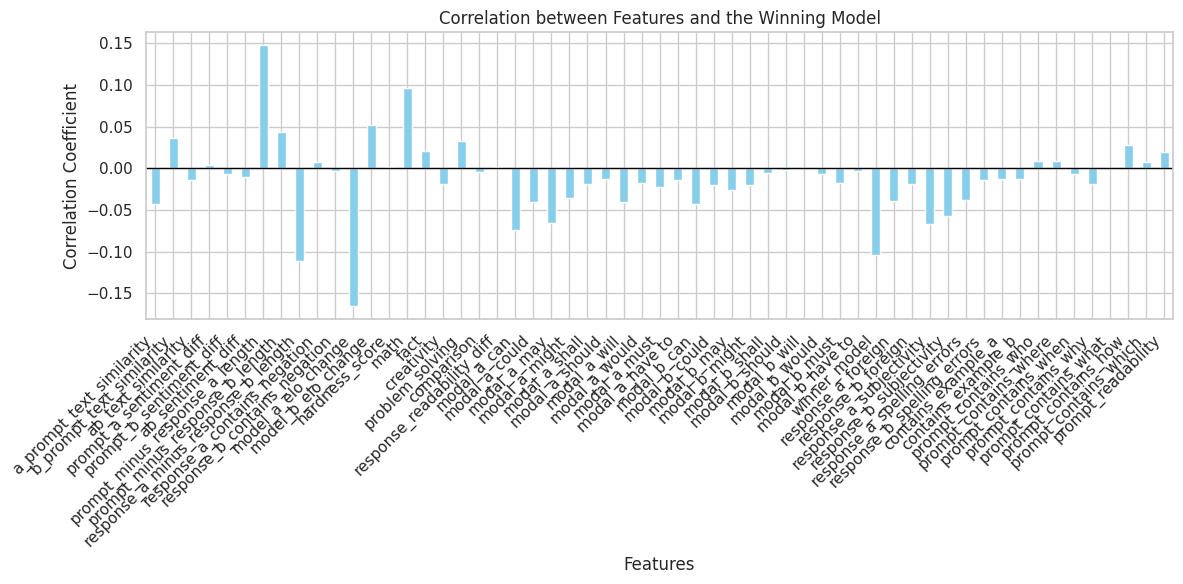

In [ ]:
#Graph feature correlations with winning models
import matplotlib.pyplot as plt

# Plot correlations (vertical bar chart)
plt.figure(figsize=(12, 6))
correlations.plot(kind='bar', color='skyblue')
plt.title("Correlation between Features and the Winning Model")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


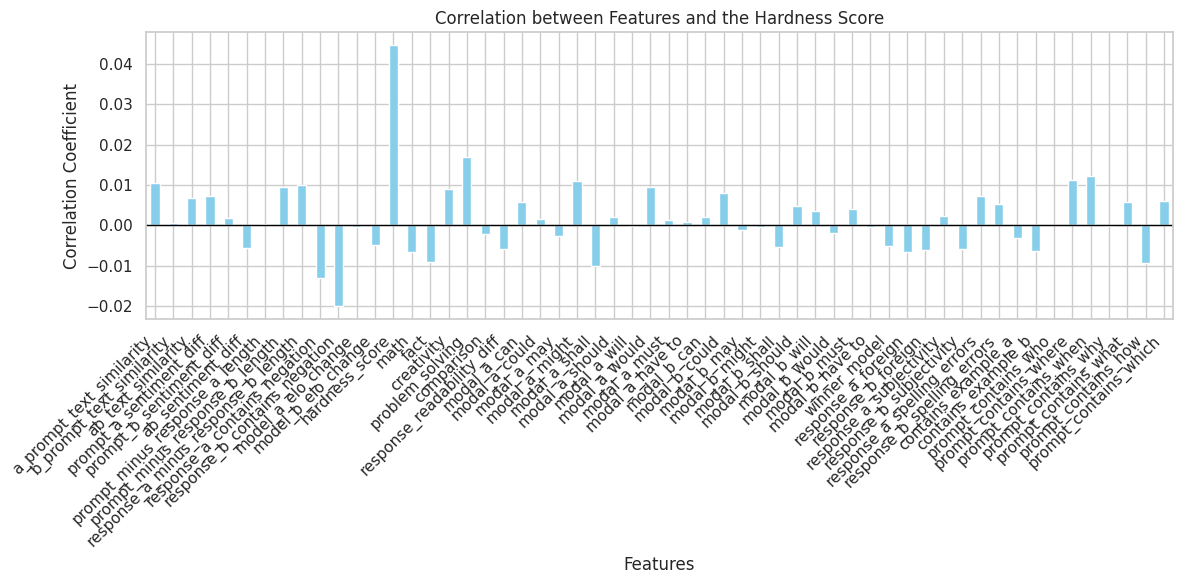

In [ ]:
#Graph feature correlations with hardness score
import matplotlib.pyplot as plt

# Plot correlations (vertical bar chart)
plt.figure(figsize=(12, 6))
correlations_2.plot(kind='bar', color='skyblue')
plt.title("Correlation between Features and the Hardness Score")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Define x-variable with just the features that had an absolute value of 0.05 correlation or more
# We will run the models with both sets of features to see if the other variables have a significant impact on the model's accuracy
X_no_corr = filtered_df[[
                 'prompt_minus_response_a_length',
                  'model_a_elo_change', 'model_b_elo_change',
                 'hardness_score', 'math', 'modal_a_can', 'modal_a_may', 'winner_model',
                  'response_a_subjectivity', 'response_b_subjectivity']]
X_no_corr_normalized = scaler.fit_transform(X_no_corr)

In [ ]:
# Split data into 80/20 train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Split data into 80/20 train and test sets with reduced x variables
X_train_nc, X_test_nc, y_train_nc, y_test_nc = train_test_split(X_no_corr_normalized, y_encoded, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Generate random predictions of test data as a baseline
def random_predictions(x_test, y_test):
    # Randomly predict target values from y_test (not features from x_test)
    random_y_preds = np.random.choice(y_test, len(y_test), replace=True)

    return random_y_preds

# Run random model on test data
random_y_preds = random_predictions(X_test, y_test)

# Calculate performance metrics for random predictions
accuracy = accuracy_score(y_test, random_y_preds)
precision = precision_score(y_test, random_y_preds, average='weighted')
recall = recall_score(y_test, random_y_preds, average='weighted')
f1 = f1_score(y_test, random_y_preds, average='weighted')


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)



Precision: 0.2870164927541848
Recall: 0.28837393543275897
F1-score: 0.2876588851694788
Accuracy: 0.28837393543275897


In [ ]:
from sklearn.model_selection import GridSearchCV
# Run a grid search for the logistic regression model to find optimal parameters

# Define the model
model = LogisticRegression(max_iter=1000)

# Define the hyperparameters grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
# Build the logistic regression model
model = LogisticRegression(C=10, penalty='l2', solver='liblinear', max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Run the model on test data
y_pred = model.predict(X_test)

In [ ]:
# Calculate evaluation metrics on the test data
# accuracy is a little too low
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

y_prob = model.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'Multiclass ROC AUC: {auc_score}')

Precision: 0.5163164316618505
Recall: 0.5272331154684096
F1-score: 0.4854494684739702
Accuracy: 0.5272331154684096
Multiclass ROC AUC: 0.7444506174579848


In [ ]:
# Train the model on reduced x variables
model.fit(X_train_nc, y_train_nc)

# Run the model on test data
y_pred_nc = model.predict(X_test_nc)

In [ ]:
# Calculate evaluation metrics on the test data
# accuracy is lower with reduced x variables
accuracy = accuracy_score(y_test_nc, y_pred_nc)
precision = precision_score(y_test_nc, y_pred_nc, average='weighted')
recall = recall_score(y_test_nc, y_pred_nc, average='weighted')
f1 = f1_score(y_test_nc, y_pred_nc, average='weighted')

y_prob_nc = model.predict_proba(X_test_nc)
auc_score = roc_auc_score(y_test_nc, y_prob_nc, multi_class='ovr', average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'Multiclass ROC AUC: {auc_score}')

Precision: 0.44303630897235585
Recall: 0.5062388591800356
F1-score: 0.45430994932966545
Accuracy: 0.5062388591800356
Multiclass ROC AUC: 0.7106604363401686


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Create a Random Forest model
clf = RandomForestClassifier(n_estimators=200, max_depth= 20, min_samples_split=5,
                            min_samples_leaf=1, max_features= 'sqrt', n_jobs=-1,
                            class_weight= None, bootstrap=True)
# Train model
clf.fit(X_train, y_train)

# Run model on Test data
y_pred_clf = clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_clf)
precision = precision_score(y_test, y_pred_clf, average='weighted')
recall = recall_score(y_test, y_pred_clf, average='weighted')
f1 = f1_score(y_test, y_pred_clf, average='weighted')

y_prob_clf = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_prob_clf, multi_class='ovr', average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'Multiclass ROC AUC: {auc_score}')

Precision: 0.5949618845203863
Recall: 0.6007130124777184
F1-score: 0.5814735356090133
Accuracy: 0.6007130124777184
Multiclass ROC AUC: 0.8243303049593732


In [ ]:
# Train model
clf.fit(X_train_nc, y_train_nc)

# Run model on Test data
y_pred_clf_nc = clf.predict(X_test_nc)

In [ ]:
# Calculate evaluation metrics for reduced x-variables
# accuracy is acceptible but lower than it is with all x-variables
accuracy_nc = accuracy_score(y_test_nc, y_pred_clf_nc)
precision_nc = precision_score(y_test_nc, y_pred_clf_nc, average='weighted')
recall_nc = recall_score(y_test_nc, y_pred_clf_nc, average='weighted')
f1_nc = f1_score(y_test_nc, y_pred_clf_nc, average='weighted')

y_prob_clf_nc = clf.predict_proba(X_test_nc)
auc_score_nc = roc_auc_score(y_test_nc, y_prob_clf_nc, multi_class='ovr', average='weighted')

print(f'Precision: {precision_nc}')
print(f'Recall: {recall_nc}')
print(f'F1-score: {f1_nc}')
print("Accuracy:", accuracy_nc)
print(f'Multiclass ROC AUC: {auc_score_nc}')

Precision: 0.5666926817339347
Recall: 0.5818974054268172
F1-score: 0.5632117569406022
Accuracy: 0.5818974054268172
Multiclass ROC AUC: 0.8046367108562968


In [ ]:
# Check for class imbalances
class_distribution = sentiment_df['winner'].value_counts()
print(class_distribution)

winner
model_a          9002
model_b          8862
tie (bothbad)    4632
tie              2786
Name: count, dtype: int64


<ipython-input-130-3f7ab02d3f20>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


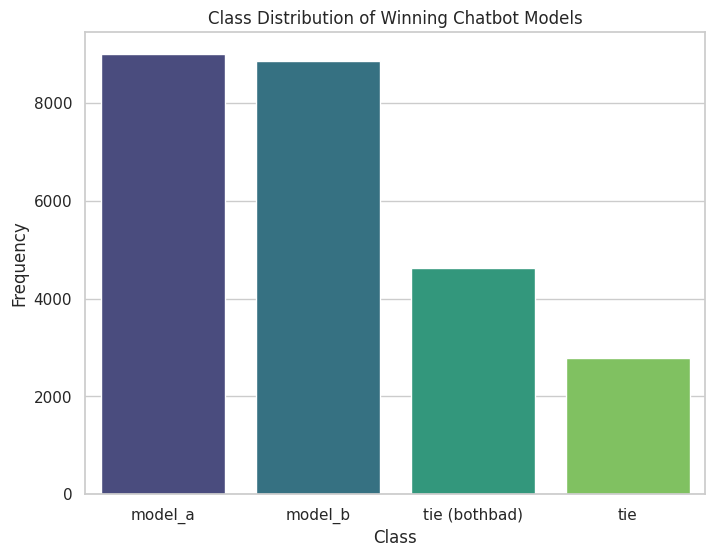

In [ ]:
# Calculate class distributions to visualize class imbalance
class_distribution = sentiment_df['winner'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution of Winning Chatbot Models')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import itertools

# Define a small grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3],
}

# Get all combinations of the grid
all_params = list(itertools.product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["min_samples_split"],
    param_grid["min_samples_leaf"],
))

best_score = 0
best_params = None

# Evaluate each combination
for params in all_params:
    clf = RandomForestClassifier(
        n_estimators=params[0],
        max_depth=params[1],
        min_samples_split=params[2],
        min_samples_leaf=params[3],
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("Best Parameters Found:", best_params)
print("Best Score:", best_score)


Best Parameters Found: (200, 20, 5, 1)
Best Score: 0.5920571623465172
